# Search-定类型-选原子

In [1]:
from My_Pka_Model_Output_Atom_Features import Pka_basic,Pka_acidic
import torch

import dgl
import dgllife
from torch.utils.data import DataLoader
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
import torch.optim as optim
import numpy as np
import random 
import pandas as pd

from torch.nn.utils import clip_grad_norm

Using backend: pytorch


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

import pandas as pd
from rdkit import rdBase, Chem, DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Draw import SimilarityMaps
%matplotlib inline

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit

In [4]:
def predict(smiles):

    acid_pred = Pka_acidic(node_feat_size = 74,
                       edge_feat_size = 12,
                       output_size = 1,
                       num_layers= 6,
                       graph_feat_size=200,
                       dropout=0.2)

    acid_pred.load_state_dict(torch.load('./Trained_model/site_acidic_new_2.pkl',map_location='cuda:0'))
    acid_pred = acid_pred.to('cpu')

    base_pred = Pka_basic(node_feat_size = 74,
                       edge_feat_size = 12,
                       output_size = 1,
                       num_layers= 6,
                       graph_feat_size=200,
                       dropout=0.2)

    base_pred.load_state_dict(torch.load('./Trained_model/site_basic_new_1.pkl',map_location='cuda:0'))
    base_pred = base_pred.to('cpu')
    
    node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
    edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
    
    bg_acid = smiles_to_bigraph(smiles= smiles, 
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,canonical_atom_order= False)

    bg_base = smiles_to_bigraph(smiles= smiles, 
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,canonical_atom_order= False)

    with torch.no_grad():
        acid_pred.eval()
        base_pred.eval()
        acid_molecule_pka,acid_atom_pka,acid_node_feats = acid_pred(bg_acid,bg_acid.ndata['h'], bg_acid.edata['h'])
        base_molecule_pka,base_atom_pka,base_node_feats = base_pred(bg_base,bg_base.ndata['h'], bg_base.edata['h'])
        
    acid_molecule_pka = -torch.log10(sum(torch.pow(10,-acid_atom_pka))).item()
    base_molecule_pka = torch.log10(sum(torch.pow(10,base_atom_pka))).item()
        
    acid_atom_pka = acid_atom_pka.tolist()
    base_atom_pka = base_atom_pka.tolist()
    
    return acid_molecule_pka,acid_atom_pka,acid_node_feats,base_molecule_pka,base_atom_pka,base_node_feats

In [5]:
# acid_molecule_pka,acid_atom_pka,acid_node_feats,base_molecule_pka,base_atom_pka,base_node_feats = predict('COC(c1c(S(=O)(NC(Nc2nc(OC)cc(OC)n2)=O)=O)cc(CNS(C)(=O)=O)cc1)=O')

# print('acid_molecule_pka:\n',acid_molecule_pka)
# print('acid_atom_pka:\n',acid_atom_pka)

# print('base_molecule_pka:\n',base_molecule_pka)
# print('base_atom_pka:\n',base_atom_pka)


In [6]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG = True

# def mol_with_atom_index( mol ):
#     atoms = mol.GetNumAtoms()
#     for idx in range( atoms ):
#         mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
#     return mol

# mol = Chem.MolFromSmiles( smiles )
# mol_with_atom_index(mol)

### 要先卡一个酸碱至少有一个预测值

In [7]:
def get_molecule_class(acid_molecule_pka,base_molecule_pka):
    if acid_molecule_pka < float('inf') and base_molecule_pka == -float('inf'):      # 碱为负无穷
        molecule_c = 'acidic'
    elif acid_molecule_pka == float('inf') and base_molecule_pka > -float('inf'):    # 酸为正无穷
        molecule_c = 'basic'
    elif acid_molecule_pka <= 12 and base_molecule_pka <= 2:                          # 酸强，碱很弱
        molecule_c = 'acidic'
    elif acid_molecule_pka >= 12 and base_molecule_pka >= 2:                          #酸弱，碱很强                        
        molecule_c = 'basic'
    elif acid_molecule_pka <= 12 and base_molecule_pka >= 2:                         # 强酸 + 强碱
        molecule_c = 'both'
    else:                                                                              #酸弱碱也弱
        molecule_c = 'both'
    return molecule_c


In [8]:
def get_atom_feature(molecule_c,acid_atom_pka,base_atom_pka):
    if molecule_c == 'both':
        most_acidic_atom_id = acid_atom_pka.index(min(acid_atom_pka))
        most_basic_atom_id = base_atom_pka.index(max(base_atom_pka))

        most_acidic_atom_feature = acid_node_feats[most_acidic_atom_id]
        most_basic_atom_feature = base_node_feats[most_basic_atom_id]

        print(most_acidic_atom_id)
        #print(most_acidic_atom_feature)
        print(most_basic_atom_id)
        #print(most_basic_atom_feature)

    elif molecule_c == 'basic':
        most_basic_atom_id = base_atom_pka.index(max(base_atom_pka))  
        most_basic_atom_feature = base_node_feats[most_basic_atom_id]

        most_acidic_atom_id = None 
        most_acidic_atom_feature = None

        print(most_acidic_atom_id)
        #print(most_acidic_atom_feature)
        print(most_basic_atom_id)
        #print(most_basic_atom_feature)

    elif molecule_c == 'acidic':
        most_acidic_atom_id = acid_atom_pka.index(min(acid_atom_pka))
        most_acidic_atom_feature = acid_node_feats[most_acidic_atom_id]

        most_basic_atom_id = None 
        most_basic_atom_feature = None

        print(most_acidic_atom_id)
        #print(most_acidic_atom_feature)
        print(most_basic_atom_id)
        #print(most_basic_atom_feature)
    
    return most_acidic_atom_id,most_basic_atom_id,most_acidic_atom_feature,most_basic_atom_feature

In [9]:
# molecule_c = get_molecule_class(acid_molecule_pka,base_molecule_pka)
# most_acidic_atom_feature,most_basic_atom_feature = get_atom_atom_feature(molecule_c,acid_atom_pka,base_atom_pka)

# Search-选smiles

##  function

In [10]:
def get_selected_acidic_smiles_lis(most_acidic_atom_feature):
    acidic_smiles_lis = []
    with open('./Search_Similar_Molecules/refined_acidic_smiles.txt') as f:
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            acidic_smiles_lis.append(line)

    all_acidic_atom_feature_jz = torch.load('./Search_Similar_Molecules/refined_acidic_atom_feature_zl.pt')
    all_acidic_atom_feature_jz.shape

    d_jz = torch.sum((all_acidic_atom_feature_jz - most_acidic_atom_feature) ** 2,axis = 1)

    selected_acidic_smiles_lis = []
    for id_ in d_jz.argsort()[:4].tolist():
        if d_jz[id_].item() < 0.05:
            selected_acidic_smiles_lis.append(acidic_smiles_lis[id_])

    #print(selected_acidic_smiles_lis)
    return(selected_acidic_smiles_lis)

In [11]:
def get_selected_basic_smiles_lis(most_basic_atom_feature):
    basic_smiles_lis = []
    with open('./Search_Similar_Molecules/refined_basic_smiles.txt') as f:
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            basic_smiles_lis.append(line)

    all_basic_atom_feature_jz = torch.load('./Search_Similar_Molecules/refined_basic_atom_feature_zl.pt')
    all_basic_atom_feature_jz.shape

    d_jz = torch.sum((all_basic_atom_feature_jz - most_basic_atom_feature) ** 2,axis = 1)

    selected_basic_smiles_lis = []
    print(d_jz.argsort()[:4])
    for id_ in d_jz.argsort()[:4].tolist():
        if d_jz[id_].item() < 0.05:
            selected_basic_smiles_lis.append(basic_smiles_lis[id_])

    return(selected_basic_smiles_lis)

In [12]:
#get_selected_acidic_smiles_lis(most_acidic_atom_feature)

In [13]:
#get_selected_basic_smiles_lis(most_basic_atom_feature)

In [14]:
def get_selected_smiles_lis(molecule_c,most_acidic_atom_feature,most_basic_atom_feature):
    
    selected_smiles_lis = []

    if molecule_c == 'acidic':
        selected_smiles_lis = get_selected_acidic_smiles_lis(most_acidic_atom_feature)

    elif molecule_c == 'basic':
        selected_smiles_lis = get_selected_basic_smiles_lis(most_basic_atom_feature)

    elif molecule_c == 'both':
        selected_acidic_smiles_lis = get_selected_acidic_smiles_lis(most_acidic_atom_feature)
        selected_basic_smiles_lis = get_selected_basic_smiles_lis(most_basic_atom_feature)
        
        print(len(selected_acidic_smiles_lis),len(selected_basic_smiles_lis))
        
        if len(selected_acidic_smiles_lis) + len(selected_basic_smiles_lis) <= 4:
            selected_smiles_lis = selected_acidic_smiles_lis + selected_basic_smiles_lis

        elif len(selected_acidic_smiles_lis) >= 2 and len(selected_basic_smiles_lis) >= 2:
            selected_smiles_lis = selected_acidic_smiles_lis[:2] + selected_basic_smiles_lis[:2]

        elif len(selected_acidic_smiles_lis) >= 3 and len(selected_basic_smiles_lis) <= 1:
            n = 4 - len(selected_basic_smiles_lis)
            selected_smiles_lis = selected_acidic_smiles_lis[:n] + selected_basic_smiles_lis

        elif len(selected_acidic_smiles_lis) <= 1 and len(selected_basic_smiles_lis) >= 3:
            n = 4 - len(selected_acidic_smiles_lis)
            selected_smiles_lis = selected_acidic_smiles_lis + selected_basic_smiles_lis[:n]
        else:
            print('error')
            
    return selected_smiles_lis

In [15]:
def draw_similar_molecule(selected_smiles):
    
    smiles = selected_smiles[0]
    legend = 'pKa = '+ str(round(float(selected_smiles[1]),2))
    id_ = int(selected_smiles[2])
    if selected_smiles[3] == 'acidic':
        color = [(1,0.9,0.9)]
    if selected_smiles[3] == 'basic':
        color = [(0.9,0.9,1)]
    #print(id_,color)

    mol = Chem.MolFromSmiles(smiles)
    cp = Chem.Mol(mol)
    d2d = rdMolDraw2D.MolDraw2DSVG(300,225)
    dos = d2d.drawOptions()
    dos.fillHighlights = True
    #dos.addAtomIndices=True
    dos.padding =0.2
    dos.legendFontSize = 18
    dos.annotationFontScale = 1
    dos.bondLineWidth = 1
    dos.setSymbolColour = 0
    dos.highlightRadius = 0.52
    #d2d.drawOptions().additionalAtomLabelPadding=True
    #d2d.drawOptions().setHighlightColour((1,0,0))
    d2d.DrawMoleculeWithHighlights(mol,legend,{id_:color},{},{},{})
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()

    return SVG(svg)

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

In [17]:
# selected_smiles_lis

In [574]:
smiles = 'Cc1nnc([C@]23CCCC(C)(C)[C@@H]2CC(=O)C2=C3C(=O)C(=O)C(C(C)C)=C2)o1'
#smiles = 'NC(N)=N'
smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
smiles

'Cc1nnc([C@]23CCCC(C)(C)[C@@H]2CC(=O)C2=C3C(=O)C(=O)C(C(C)C)=C2)o1'

In [575]:
acid_molecule_pka,acid_atom_pka,acid_node_feats,base_molecule_pka,base_atom_pka,base_node_feats = predict(smiles)

print('acid_molecule_pka:\n',acid_molecule_pka)
print('acid_atom_pka:\n',acid_atom_pka)

print('base_molecule_pka:\n',base_molecule_pka)
print('base_atom_pka:\n',base_atom_pka)

acid_molecule_pka:
 inf
acid_atom_pka:
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
base_molecule_pka:
 0.739264190196991
base_atom_pka:
 [-inf, -inf, 0.7392611503601074, -4.41998815536499, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]


In [576]:
# mol = Chem.MolFromSmiles( smiles )
# mol_with_atom_index(mol)

In [577]:
molecule_c = get_molecule_class(acid_molecule_pka,base_molecule_pka)
print(molecule_c)
most_acidic_atom_id,most_basic_atom_id,most_acidic_atom_feature,most_basic_atom_feature = get_atom_feature(molecule_c,acid_atom_pka,base_atom_pka)

basic
None
2


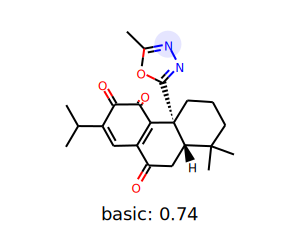

In [578]:
mol = Chem.MolFromSmiles(smiles)
cp = Chem.Mol(mol)
d2d = rdMolDraw2D.MolDraw2DSVG(300,225)
dos = d2d.drawOptions()
dos.fillHighlights = True
#dos.addAtomIndices=True
dos.padding =0.2
dos.legendFontSize = 18
dos.annotationFontScale = 1
dos.bondLineWidth = 1
dos.setSymbolColour = 0
dos.highlightRadius = 0.52
#d2d.drawOptions().additionalAtomLabelPadding=True
#d2d.drawOptions().setHighlightColour((1,0,0))
if molecule_c == 'acidic':
    d2d.DrawMoleculeWithHighlights(mol,"acidic: "+str(round(float(acid_molecule_pka),2)),{most_acidic_atom_id:[(1,0.9,0.9)]},{},{},{})
elif molecule_c == 'basic':
    d2d.DrawMoleculeWithHighlights(mol,"basic: "+str(round(float(base_molecule_pka),2)),{most_basic_atom_id:[(0.9,0.9,1)]},{},{},{})
elif molecule_c == 'both':
    d2d.DrawMoleculeWithHighlights(mol,"acidic: "+str(round(float(acid_molecule_pka),2))+ ' '+"basic: " +str(round(float(base_molecule_pka),2)),{most_acidic_atom_id:[(1,0.9,0.9)],most_basic_atom_id:[(0.9,0.9,1)]},{},{},{})
d2d.FinishDrawing()
svg = d2d.GetDrawingText()

SVG(svg)

In [579]:
selected_smiles_lis = get_selected_smiles_lis(molecule_c,most_acidic_atom_feature,most_basic_atom_feature)
selected_smiles_lis

tensor([6003, 2616, 6036, 1138])


[]

In [580]:
draw_similar_molecule(selected_smiles_lis[0])

IndexError: list index out of range

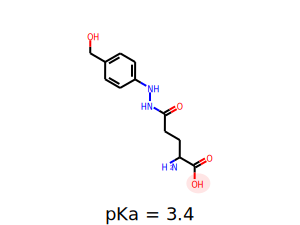

In [571]:
draw_similar_molecule(selected_smiles_lis[1])

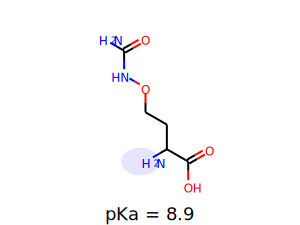

In [572]:
draw_similar_molecule(selected_smiles_lis[2])

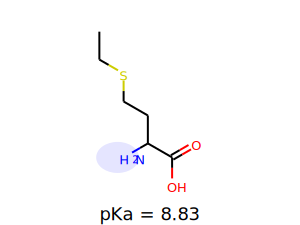

In [573]:
draw_similar_molecule(selected_smiles_lis[3])

In [ ]:
smis=[i[0] for i in selected_smiles_lis]
legend_lis = ['pKa = ' + str(round(float(i[1]),2)) for i in selected_smiles_lis]

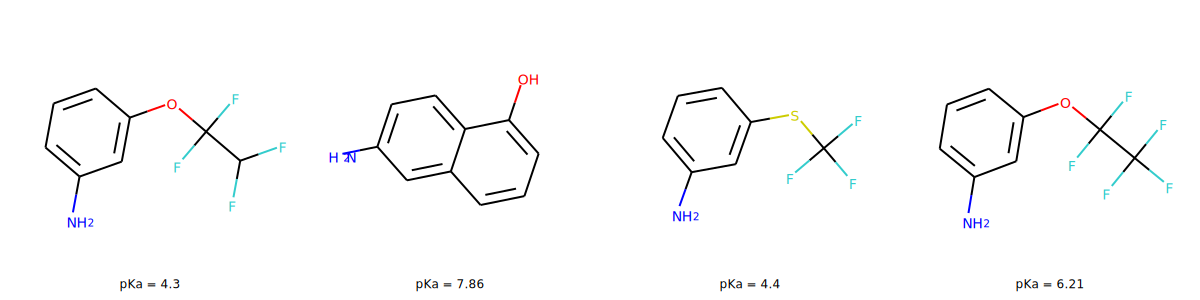

In [160]:
smis=[i[0] for i in selected_smiles_lis]
legend_lis = ['pKa = ' + str(round(float(i[1]),2)) for i in selected_smiles_lis]

mols = []

for smi in smis:
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=len(selected_smiles_lis),
    subImgSize=(300,300),
    legends=legend_lis
)

img

In [161]:
smiles = 'Nc1cccc(OC(F)(F)C(F)F)c1'

In [185]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit


mol = Chem.MolFromSmiles(smiles)
cp = Chem.Mol(mol)
d2d = rdMolDraw2D.MolDraw2DSVG(400,300)
dos = d2d.drawOptions()
dos.atomHighlightsAreCricle = True
dos.fillHighlights = False
#dos.addAtomIndices=True
dos.padding =0.1
dos.annotationFontScale = 1
dos.bondLineWidth = 1
dos.setSymbolColour = 0
#dos.highlightRadius = 0.52
#d2d.drawOptions().additionalAtomLabelPadding=True
#d2d.drawOptions().setHighlightColour((1,0,0))
d2d.DrawMoleculeWithHighlights(mol,"",{0:[(1,0,0)]},{},{},{},legend = 'a')
d2d.FinishDrawing()
svg = d2d.GetDrawingText()

SVG(svg)

In [204]:
mol = Chem.MolFromSmiles(smiles)
cp = Chem.Mol(mol)
d2d = rdMolDraw2D.MolDraw2DSVG(400,300)
dos = d2d.drawOptions()
dos.atomHighlightsAreCricle = True
dos.fillHighlights = False
#dos.addAtomIndices=True
dos.padding =0.1
dos.annotationFontScale = 1
dos.bondLineWidth = 1
dos.setSymbolColour = 0
#dos.highlightRadius = 0.52
#d2d.drawOptions().additionalAtomLabelPadding=True
#d2d.drawOptions().setHighlightColour((1,0,0))
d2d.DrawMoleculeWithHighlights(mol,"",{0:[(1,0,0)]},{},{},{})
d2d.FinishDrawing()
svg = d2d.GetDrawingText()


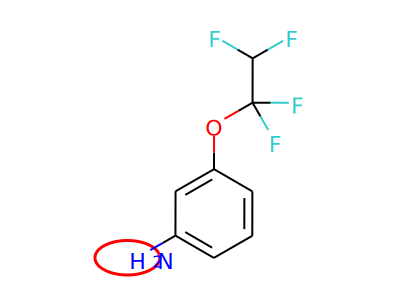

In [207]:
SVG(svg)

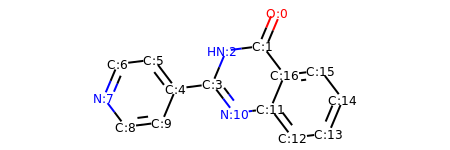

In [98]:
mol = Chem.MolFromSmiles('O=c1[nH]c(-c2ccncc2)nc2ccccc12')
mol_with_atom_index(mol)

In [174]:
basic_smiles_lis = []
with open('./Search_Similar_Molecules/refined_basic_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('\t')
        basic_smiles_lis.append(line)

In [175]:
count = 0
for i in basic_smiles_lis:
    #print(i[0])
    if 'COc1ccc([C@@]2(c3cccc(-c4cncnc4)c3)N=C(C)C(N)=N2)cc1C' == i[0]:
        print(i)
        print(count)
    count += 1

['COc1ccc([C@@]2(c3cccc(-c4cncnc4)c3)N=C(C)C(N)=N2)cc1C', '4.73', '24', 'basic']
7447


In [176]:

basic_smiles_lis = []
with open('./Search_Similar_Molecules/refined_basic_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('\t')
        basic_smiles_lis.append(line)

all_basic_atom_feature_jz = torch.load('./Search_Similar_Molecules/refined_basic_atom_feature_zl.pt')
all_basic_atom_feature_jz.shape

d_jz = torch.sum((all_basic_atom_feature_jz - most_basic_atom_feature) ** 2,axis = 1)

selected_basic_smiles_lis = []
print(d_jz.argsort()[:4])
for id_ in d_jz.argsort()[:4].tolist():
    if d_jz[id_].item() < 0.06:
        selected_basic_smiles_lis.append(basic_smiles_lis[id_])



tensor([4900, 5497, 7189, 4848])


In [167]:
d_jz[7447]

tensor(11.3124)

In [157]:
get_selected_basic_smiles_lis(most_basic_atom_feature)

tensor([4900, 5497, 7189, 4848])


[]

In [14]:
smiles_clusters[100]

['O=C(O)[C@H]1CCC[C@H]1C(=O)O',
 'O=C(O)C1CCCC1C(=O)O',
 'O=C(O)[C@H]1CCC[C@@H]1C(=O)O']

In [14]:
for i in clusters[100]:
    print(i)

7132
6059
7061


O=C(O)[C@H]1CCC[C@H]1C(=O)O


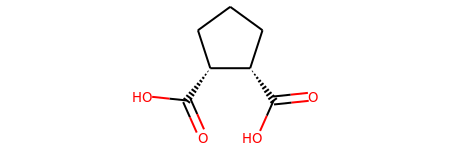

In [11]:
print(smiles_lis[7132])
Chem.MolFromSmiles(smiles_lis[7132])

O=C(O)C1CCCC1C(=O)O


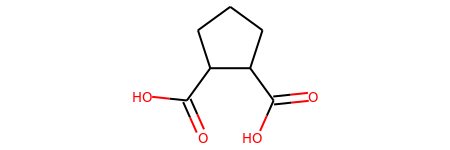

In [12]:
print(smiles_lis[6059])
Chem.MolFromSmiles(smiles_lis[6059])

O=C(O)[C@H]1CCC[C@@H]1C(=O)O


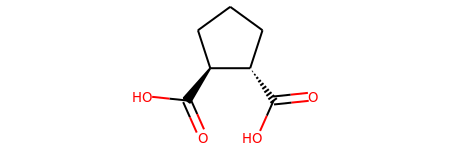

In [13]:
print(smiles_lis[7061])
Chem.MolFromSmiles(smiles_lis[7061])

O=C(O)[C@@H]1C[C@@H]2CC[C@H]1C2


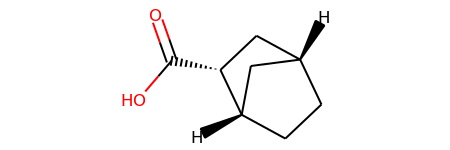

In [45]:
print(smiles_lis[7455])
Chem.MolFromSmiles(smiles_lis[7455])

# get acidic dataset

In [4]:
batch_size = 1024
epoch_num = 1000
layer_num = 6
learning_rate = 0.0003
weight_decay = 0.0003

In [1]:
model = Pka_acidic(node_feat_size = 74,
                   edge_feat_size = 12,
                   output_size = 1,
                   num_layers= layer_num,
                   graph_feat_size=200,
                   dropout=0.2)

model.load_state_dict(torch.load('./Trained_model/site_acidic_new_2.pkl',map_location='cuda:0'))
model = model.to('cpu')

In [ ]:
# 先去重，去完后自己换就ok了